# Cross validation

> In this example, we'll implement time series cross-validation to evaluate model's performance. 

::: {.callout-warning collapse="true"}

## Prerequisites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short)
:::

## Introduction 

Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif) 

[Statsforecast](../../statsforecast) has an implementation of time series cross-validation that is fast and easy to use. This implementation makes cross-validation a distributed operation, which makes it less time-consuming. In this notebook, we'll use it on a subset of the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) hourly dataset. 

**Outline:**

1. Install libraries 
2. Load and explore data 
3. Train model
4. Perform time series cross-validation 
5. Evaluate results 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

Install the necessary packages with `pip install statsforecast`

In [ ]:
pip install statsforecast

In [1]:
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

from statsforecast import StatsForecast # required to instantiate StatsForecast object and use cross-validation method

/Users/nasaul/nixtla/statsforecast/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and explore the data

As stated in the introduction, we'll use the M4 Competition hourly dataset. We'll first import the data from an URL using `pandas`. 

In [2]:
import pandas as pd

In [3]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet') # load the data
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to `StatsForecast` is a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and y: 

- The `unique_id` (string, int, or category) represents an identifier for the series. 
- The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS. 
- The `y` (numeric) represents the measurement we wish to forecast. 

The data in this example already has this format, so no changes are needed. 

To keep the time required to execute this notebook to a minimum, we'll only use one time series from the data, namely the one with `unique_id == 'H1'`. However, you can use as many as you want, with no additional changes to the code needed. 

In [4]:
df = Y_df[Y_df['unique_id'] == 'H1'] # select time series

We can plot the time series we'll work with using `StatsForecast.plot` method.  

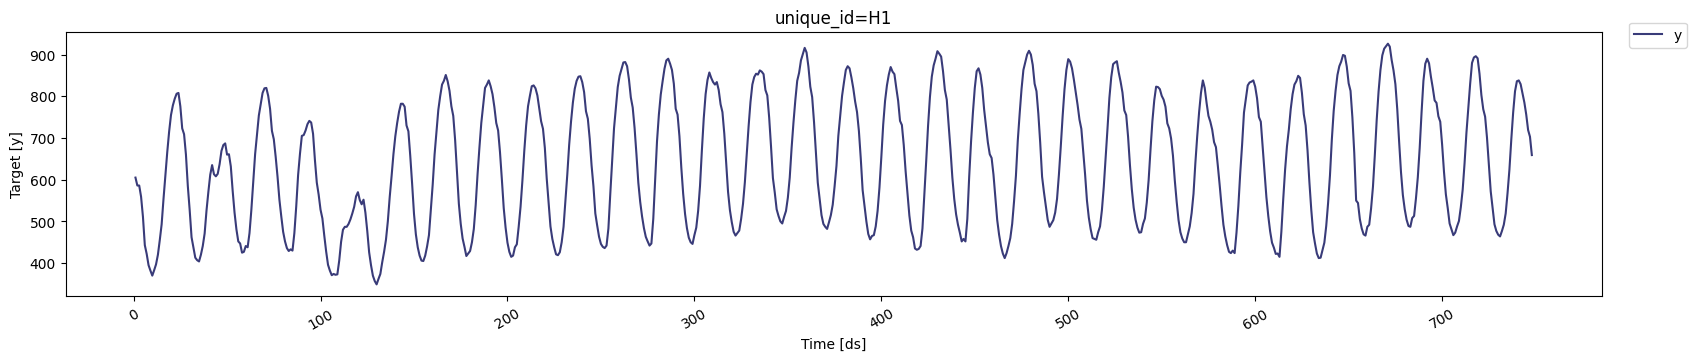

In [5]:
StatsForecast.plot(df)

## Train model

For this example, we'll use StatsForecast [AutoETS](../models/AutoETS). We first need to import it from `statsforecast.models` and then we need to instantiate a new `StatsForecast` object. 

The `StatsForecast` object  has the following parameters: 

- models: a list of models. Select the models you want from [models](../../models/) and import them.
- freq: a string indicating the frequency of the data. See [panda’s available frequencies.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
- n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame `df`. 

In [6]:
from statsforecast.models import AutoETS

In [7]:
models = [AutoETS(season_length = 24)]

sf = StatsForecast(
    models = models,
    freq = 1,
    n_jobs = 1
)

## Perform time series cross-validation

Once the `StatsForecast`object has been instantiated, we can use the `cross_validation` method, which takes the following arguments: 

- `df`: training data frame with `StatsForecast` format 
- `h` (int): represents the h steps into the future that will be forecasted 
- `step_size` (int): step size between each window, meaning how often do you want to run the forecasting process. 
- `n_windows` (int): number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate. 

For this particular example, we'll use 3 windows of 24 hours.

In [8]:
cv_df = sf.cross_validation(
    df = df,
    h = 24,
    step_size = 24,
    n_windows = 3
  )

The `cv_df` object is a new data frame that includes the following columns:

- `unique_id`: series identifier
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. 
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [9]:
cv_df.head()

,unique_id,ds,cutoff,y,AutoETS
0,H1,677,676,691.0,677.761053
1,H1,678,676,618.0,607.817879
2,H1,679,676,563.0,569.437729
3,H1,680,676,529.0,537.340007
4,H1,681,676,504.0,515.571123


We'll now plot the forecast for each cutoff period. To make the plots clearer, we'll rename the actual values in each period. 

In [10]:
from IPython.display import display

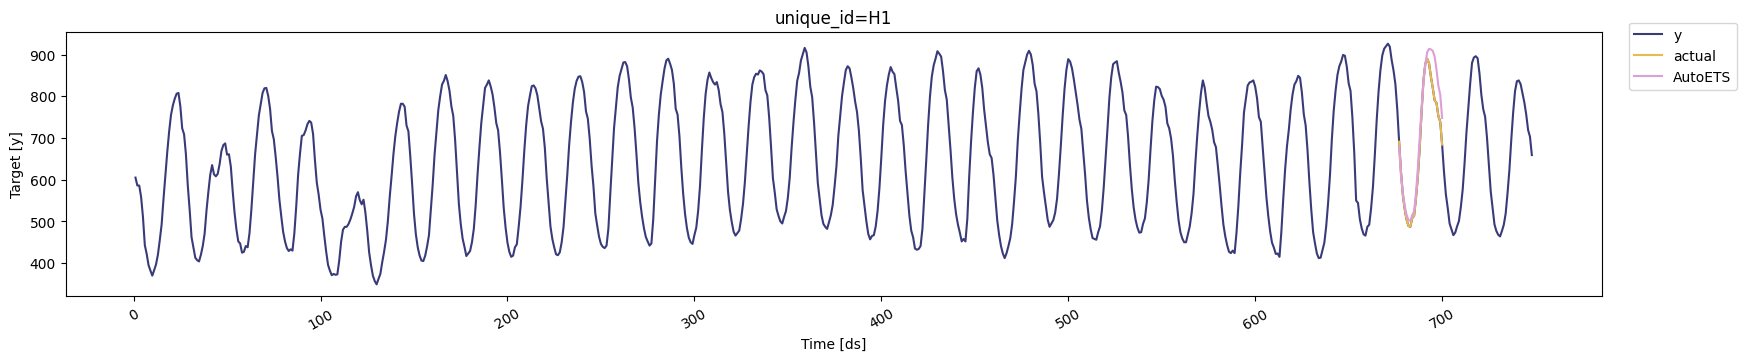

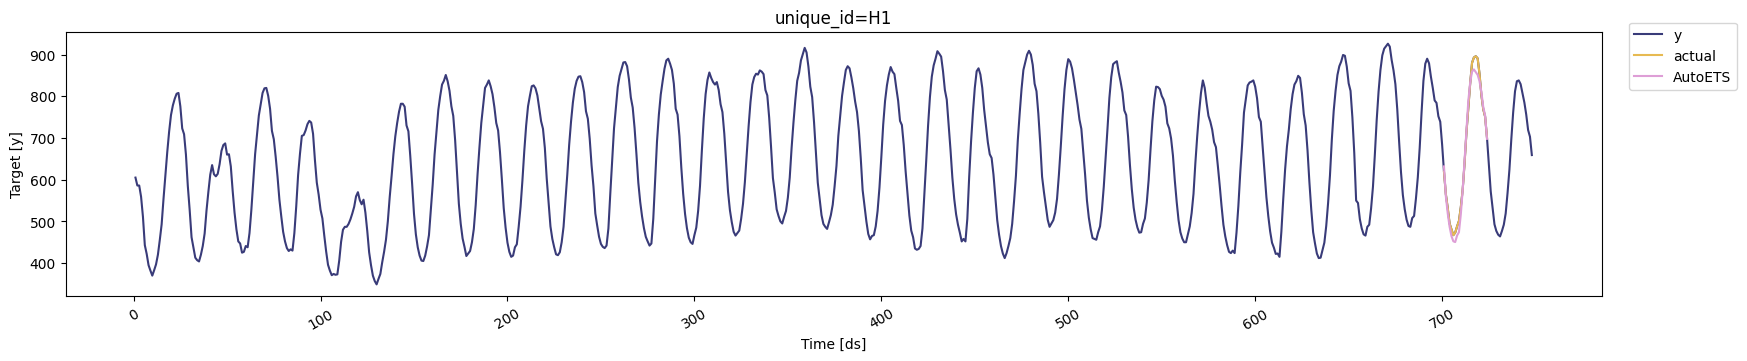

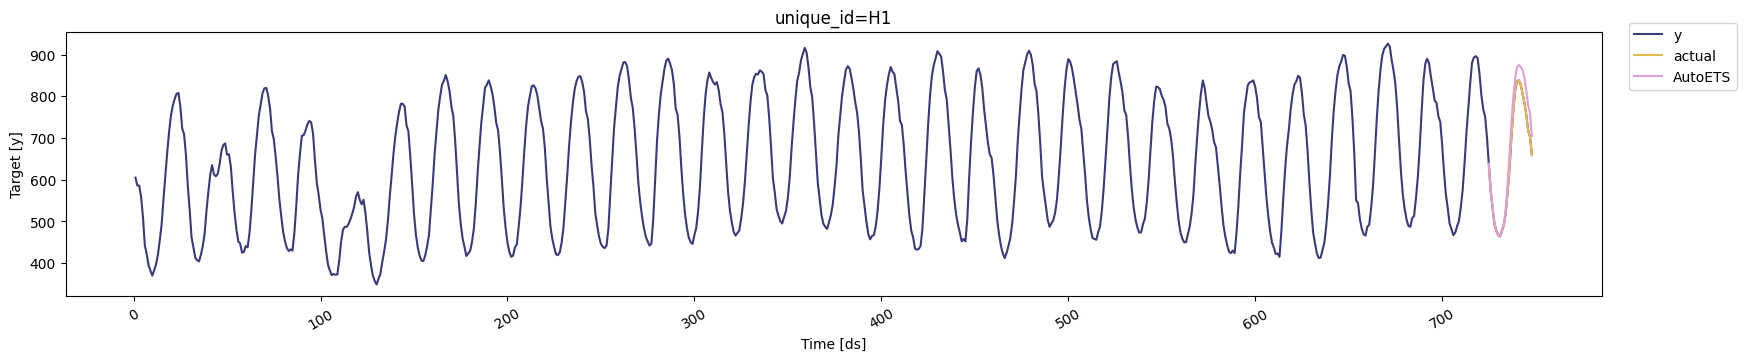

In [11]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values

cutoff = cv_df['cutoff'].unique()

for k in range(len(cutoff)):
    cv = cv_df[cv_df['cutoff'] == cutoff[k]]
    display(StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff']))

Notice that in each cutoff period, we generated a forecast for the next 24 hours using only the data `y` before said period.  

## Evaluate results 

We can now compute the accuracy of the forecast using an appropriate accuracy metric. Here we'll use the [Root Mean Squared Error (RMSE).](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [12]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

The function to compute the RMSE takes two arguments: 
    
1. The actual values.  
2. The forecasts, in this case, `AutoETS`. 

In [13]:
cv_rmse = evaluate(cv_df, metrics=[rmse], models=['AutoETS'], target_col='actual', agg_fn='mean')['AutoETS'].mean()
print(f"RMSE using cross-validation: {cv_rmse:.2f}")

RMSE using cross-validation: 32.21


This measure should better reflect the predictive abilities of our model, since it used different time periods to test its accuracy. 

::: {.callout-tip}
Cross validation is especially useful when comparing multiple models. Here's an [example](../getting-started/2_Getting_Started_complete) with multiple models and time series. 
::: 

## References 

[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Time series cross-validation"](https://otexts.com/fpp3/tscv.html).